# Evaluate model for US Stock Env

In [1]:
import torch as th
import vectorbt as vbt
import gymnasium as gym
from stock_env.common.common_utils import create_performance, plot_trade_log_v2
from stock_env.envs import *
from stock_env.common.evaluation import evaluate_agent, play_an_episode

In [2]:
from stock_env.algos.agent import MetaAgent


task_env = MetaVectorEnv([lambda: gym.make('FAANGTask-v0') for _ in range(1)])
agent = MetaAgent(task_env)
state_dict = th.load('/Users/manbnm/stock-env/model/maml_2022-12-04_15-00-17.pth')
agent.load_state_dict(state_dict)
agent.eval()
task_env.train(False)

# Evaluation

## Evaluation on random period

In [3]:
mean, std = evaluate_agent(agent, task_env, n_eval_episodes=10)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -75.75 +/-  266.36


# Evaluation on specific stock

In [4]:
list_task = task_env.sample_task(1)
print(f"Ticker: {list_task[0]}")
task_env.reset_task(list_task[0])

# run model to get detailed information in the enviroment
info = play_an_episode(agent, task_env)
df = info['final_info'][0]['final_history']
df.head()

Ticker: GOOG


,time,open,high,low,close,volume,ticker_x,quantity,actions,delta_shares,portfolio_value,nav,cash,step_reward,ticker_y
0,2021-12-01 00:00:00-05:00,144.212494,146.499146,141.500000,141.617996,28476000,GOOG,0,1.000000,0,20000.0,0.0,20000.0,-1.0,GOOG
1,2021-12-02 00:00:00-05:00,141.824005,144.675003,140.981995,143.776505,21250000,GOOG,0,0.301800,0,20000.0,0.0,20000.0,-2.0,GOOG
2,2021-12-03 00:00:00-05:00,144.495499,145.212997,141.149994,142.520493,26688000,GOOG,0,0.435679,0,20000.0,0.0,20000.0,-2.0,GOOG
3,2021-12-06 00:00:00-05:00,143.574005,144.351501,140.647003,143.796494,22198000,GOOG,0,0.517522,0,20000.0,0.0,20000.0,-2.0,GOOG
4,2021-12-07 00:00:00-05:00,145.949997,148.300003,145.702499,148.036499,23258000,GOOG,0,0.679314,0,20000.0,0.0,20000.0,-2.0,GOOG



    Annual return     : -36.05%
    Cumulative return : -35.83%
    Sharpe ratio      : -1.56
    Maximum Drawdown  : -38.52%
    Annual Volatility :  26.48%
    Value-At-Risk     :  nan%
    


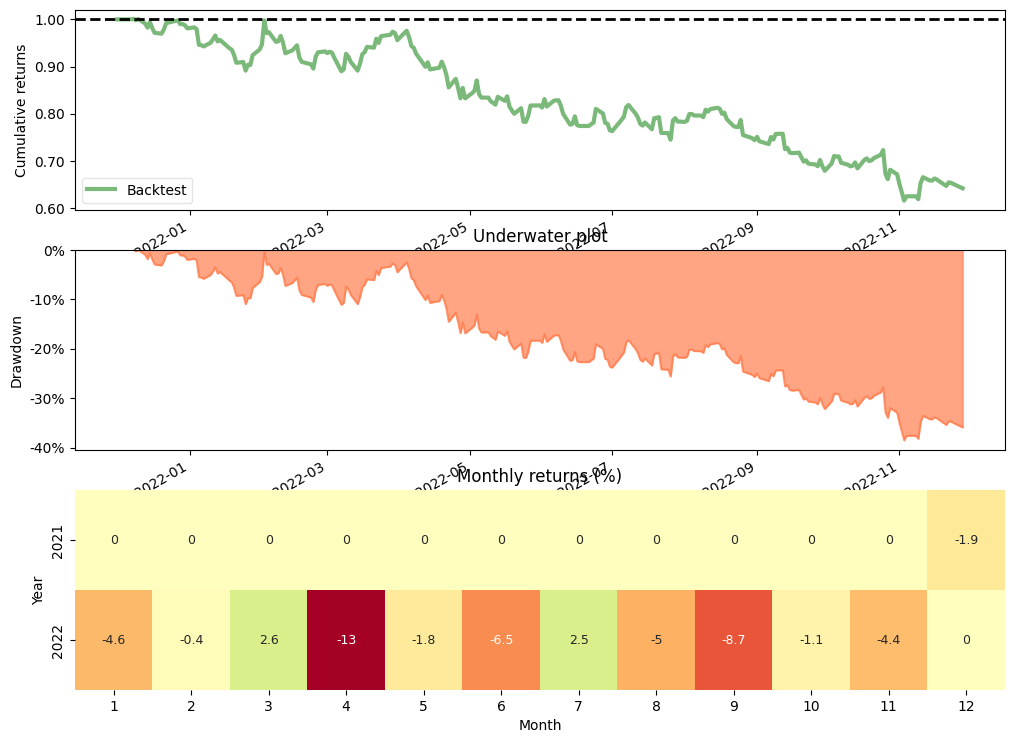

In [6]:
returns = df.set_index('time')['portfolio_value'].pct_change()
create_performance(returns)

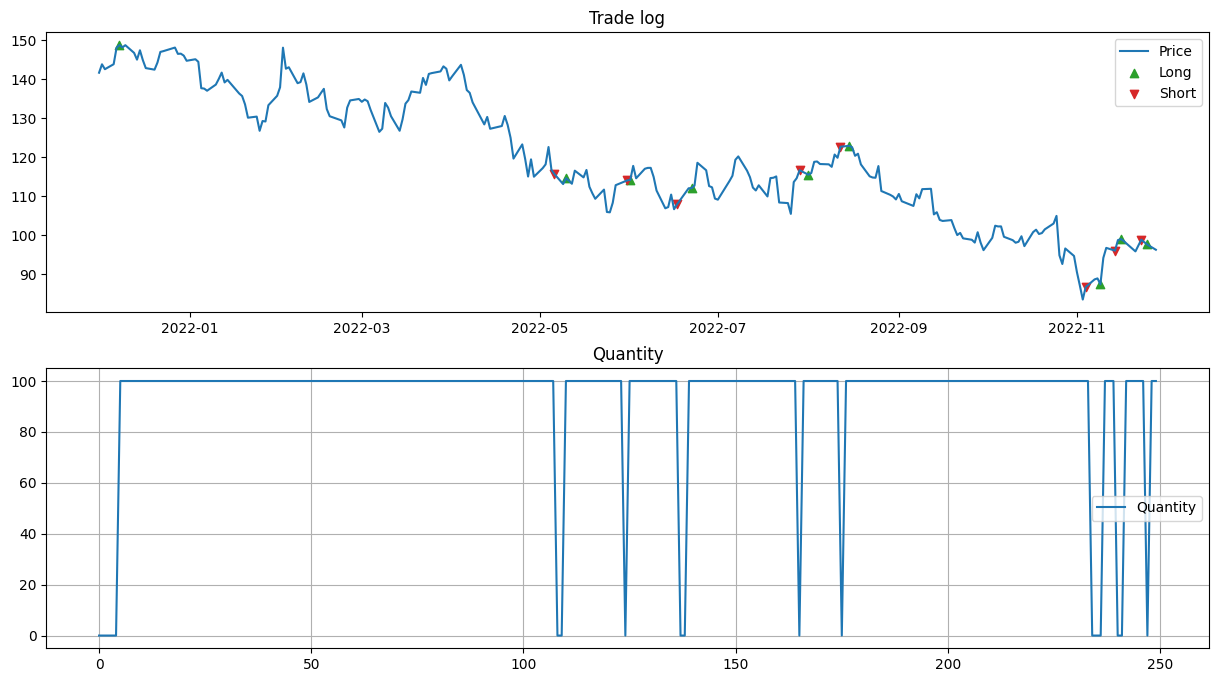

In [7]:
plot_trade_log_v2(df)

# Compare with buy-and-hold strategy and feature strategy

In [8]:
# portfolio value from hodling
df['pv_from_holding'] = vbt.Portfolio.from_holding(df.close, init_cash=20e3).value()
fig = df['portfolio_value'].vbt.plot_against(df['pv_from_holding'])
fig.show()